# Modelling

We will build a class that will allow us to run the data through several regression models, including a neural network.

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()
import warnings
warnings.filterwarnings('ignore')

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import pickle
import pylab as plot
params = {'legend.fontsize': 18}
plot.rcParams.update(params)

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import (AdaBoostRegressor,
                                BaggingRegressor,
                                ExtraTreesRegressor,
                                GradientBoostingRegressor,
                                IsolationForest,
                                RandomForestRegressor,
                                RandomTreesEmbedding)

#from sklearn.ensemble import VotingRegressor, HistGradientBoostingRegressor

from sklearn.linear_model import (ARDRegression,
                                    BayesianRidge,
                                    ElasticNet,
                                    ElasticNetCV,
                                    HuberRegressor,
                                    Lars,
                                    LarsCV,
                                    Lasso,
                                    LassoCV,
                                    LassoLars,
                                    LassoLarsCV,
                                    LassoLarsIC,
                                    LinearRegression,
                                    LogisticRegression,
                                    LogisticRegressionCV,
                                    MultiTaskLasso,
                                    MultiTaskElasticNet,
                                    MultiTaskLassoCV,
                                    MultiTaskElasticNetCV,
                                    OrthogonalMatchingPursuit,
                                    OrthogonalMatchingPursuitCV,
                                    PassiveAggressiveClassifier,
                                    PassiveAggressiveRegressor,
                                    Perceptron,
                                    RANSACRegressor,
                                    Ridge,
                                    RidgeClassifier,
                                    RidgeClassifierCV,
                                    RidgeCV,
                                    SGDClassifier,
                                    SGDRegressor,
                                    TheilSenRegressor,
                                    enet_path,
                                    lars_path,
                                    lasso_path,
                                    orthogonal_mp,
                                    orthogonal_mp_gram,
                                    ridge_regression)





from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Regression metrics
from sklearn.metrics import explained_variance_score, mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
# Construction of a bikesales modelling class

class bikeSales:
    
    # Initialise the class fields
    def __init__(self):

        self.file = 'clean_sport.csv'
        self.df = None
        self.scaled_df = None
        self.model = {'Name': 'RidgeCV',
                      'Model': RidgeCV(cv=5),
                      'Features': [],
                      'Score': 0}
        
    
    
    # read the data in
    def read_data(self):
        df = pd.read_csv(self.file,
                         parse_dates=['First_Seen','Last_Seen','Last_Modified'], 
                         infer_datetime_format=True)
        
        df.drop(['Suburb','Postcode'], axis=1, inplace=True)
        
        self.df = df
        
        return None

    # convert the categorical features to dummy variables
    def add_dummy_variables(self, categorical_features=None):
        
        if (categorical_features == None):
            categorical_features = self.df.select_dtypes(exclude='number').columns
            
        # ignore the URL feature when training
        categorical_features = list(set(categorical_features) - set('URL'))

        additional = pd.get_dummies(self.df[categorical_features])
        self.df[additional.columns] = additional
        
        self.df.drop(categorical_features, axis=1, inplace=True)
        
        return None

    # plot the prediction accuracy
    def plot_accuracy_predictions(self, y_test, pred):
        fig, ax = plt.subplots(figsize=(12,10))
        ax.scatter(y_test,pred)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=0.8)
        ax.set_xlabel('Measured')
        ax.set_ylabel('Predicted')
        ax.set_title('Accuracy of Predictions')
        
        return None
    
    
    # Optinally scale the data.
    def scale_data(self, target='Price'):
        local_df = self.df.select_dtypes(include='number')

        features = list(set(local_df.columns) - set([target]))

        sc = StandardScaler()
        sc.fit(self.df[features])
        s = sc.transform(self.df[features])
        self.scaled_df = pd.DataFrame(s,columns=features)

        return None
    
    # Calculate the adjsuted R squared value
    def adjusted_r2(self, r2, n, k):
        if (n-k-1 == 0):
            return r2
        else:
            return 1 - (1-r2)*((n-1)/(n-k-1))

        
    # Split the data in to dealer and private sets as the training and testing set.
    def dealer_split_data(self,features):
        
        train = self.df[self.df['Seller_Dealer'] == 1]
        test = self.df[self.df['Seller_Dealer'] == 0]

        X_train, y_train = train[features], train['Price']
        X_test, y_test = test[features], test['Price']

        return X_train, y_train, X_test, y_test

    # split the data randomly into training and testing set.
    def split_data(self, features, scaled=False, test_size=0.3, random_state=1):
        
        self.model['Features'] = features
        X = self.df[features]
        y = self.df['Price']
        
        if scaled == True:
            X = self.scaled_df[features]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state, test_size=test_size)
        
        return X_train, X_test, y_train, y_test
    
    # Search through multiple models for the best regression model. 
    def find_best_model(self, features, y, scaled=False):
        
        X_train, X_test, y_train, y_test = self.split_data(features)

        best_score = 0
        models = []
        crossValidation=5
        
                
        models.append(("ARDRegression",ARDRegression()))
        models.append(("BayesianRidge",BayesianRidge()))
        models.append(("ElasticNet",ElasticNet()))
        models.append(("ElasticNetCV",ElasticNetCV(cv=crossValidation)))
        models.append(("Lars",Lars()))
        models.append(("LarsCV",LarsCV(cv=crossValidation)))
        models.append(("Lasso",Lasso()))
        models.append(("LassoCV",LassoCV(cv=crossValidation)))
        models.append(("LassoLars",LassoLars()))
        models.append(("LassoLarsCV",LassoLarsCV(cv=crossValidation)))
        models.append(("LassoLarsIC",LassoLarsIC()))
        models.append(("LinearRegression",LinearRegression()))
        #models.append(("LogisticRegression",LogisticRegression()))
        #models.append(("LogisticRegressionCV",LogisticRegressionCV(cv=crossValidation)))
        models.append(("OrthogonalMatchingPursuit",OrthogonalMatchingPursuit()))
        models.append(("OrthogonalMatchingPursuitCV",OrthogonalMatchingPursuitCV(cv=crossValidation)))
        models.append(("PassiveAggressiveClassifier",PassiveAggressiveClassifier()))
        models.append(("PassiveAggressiveRegressor",PassiveAggressiveRegressor()))
        models.append(("Perceptron",Perceptron()))
        models.append(("Ridge",Ridge()))
        models.append(("RidgeClassifier",RidgeClassifier()))
        models.append(("RidgeClassifierCV",RidgeClassifierCV(cv=crossValidation)))
        models.append(("RidgeCV",RidgeCV(cv=crossValidation)))
        models.append(("SGDClassifier",SGDClassifier()))
        models.append(("SGDRegressor",SGDRegressor()))
        
        models.append(("AdaBoostRegressor",AdaBoostRegressor()))
        models.append(("BaggingRegressor",BaggingRegressor()))
        #models.append(("ExtraTreesRegressor",ExtraTreesRegressor()))
        models.append(("GradientBoostingRegressor",GradientBoostingRegressor()))
        #models.append(("IsolationForest",IsolationForest()))
        models.append(("RandomForestRegressor",RandomForestRegressor()))
        #models.append(("RandomTreesEmbedding",RandomTreesEmbedding()))
        
        n, k = X_train.shape

        for name, model in models:
            score = cross_val_score(model, X_train, y_train,  cv=5)
            
            print (name, score.mean())
            if name == models[0][0]:
                best_score = score.mean()
            
            if ((score.mean() > best_score) & (score.mean() <= 1)):
                best_score = score.mean()
                self.model['Name'] = name
                self.model['Model'] = model
                self.model['Score'] = score.mean()
                
        return None


    def optimise_best_model(self):
        
        # Set the values for all possibilities of parameter tuning
        n_iter=[100,300,500,1000]
        max_iter = n_iter
        alpha_1=[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3]
        alpha_2=[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3]
        lambda_1=[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3]
        lambda_2=[1e-8,1e-7,1e-6,1e-5,1e-4,1e-3]
        fit_intercept=[True, False]
        normalize=[True, False]
        alphas = [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1.0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6]
        alpha = [0.1, 0.3, 0.5, 0.6, 0.75, 0.9, 0.95]
        l1_ratio=[0,0.1,0.3,0.6,0.8,1.0]
        n_nonzero_coefs=[100,300,500,800,1000,np.inf]
        criterion = ['bic', 'aic']
        penalty=['l1','l2','elasticnet'] 
        regularizationStrength=[1e-4,1e-3,1e-2,1e-1,1.0,10,100,1000]
        solver=['auto','svd','cholesky','lsqr','sparse_cg','sag','saga']
        learning_rate = [1e-3, 1e-2, 1e-1, 1.0]
        n_estimators = [50,100,200,300,400,500]
        loss = ['linear','square','exponential']
        ensemble_loss = ['ls','lad','huber','quantile']
        max_samples = [0.3, 0.5, 0.7, 0.9, 1.0]
        bootstrap = [True, False]
        bootstrap_features = [True, False]
        oob_score = [True, False]
        criterion_split = ['mse','mae']
        max_depth = [5, 10, 15, 20, 25, 50, 100, 200]
        contamination = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
        l2_regularization = [0, 0.2, 0.5, 0.7, 0.9, 1.0]
        max_bins = [10, 50, 100, 150, 200, 256]
        
        crossValidation=5

        X_train, X_test, y_train, y_test = self.split_data(self.model['Features'])

        
        if self.model['Name'] in ['ARDRegression','BayesianRidge']:
            
            best = {'score': 0,
                    'n_iter': 500,
                    'alpha_1': 1e-6,
                    'alpha_2': 1e-6,
                    'lambda_1': 1e-4,
                    'lambda_2': 1e-4,
                    'fit_intercept': True,
                    'normalize': True}

            for n in n_iter:
                for a1 in alpha_1:
                    for a2 in alpha_2:
                        for l1 in lambda_1:
                            for l2 in lambda_2:
                                for intercept in fit_intercept:
                                    for norm in normalize:


                                        if self.model['Name'] == 'ARDRegression':
                                            model = ARDRegression(n_iter=n,alpha_1=a1,alpha_2=a2,lambda_1=l1,
                                                                    lambda_2=l2,fit_intercept=intercept, normalize=norm)

                                        if self.model['Name'] == 'BayesianRidge':
                                            model = BayesianRidge(n_iter=n,alpha_1=a1,alpha_2=a2,lambda_1=l1,
                                                                    lambda_2=l2,fit_intercept=intercept, normalize=norm)

                                        model.fit(X_train, y_train)
                                        score = model.score(X_train, y_train)

                                        if score > best['score']:
                                                best = {'score': score,
                                                        'n_iter': n,
                                                        'alpha_1': a1,
                                                        'alpha_2': a2,
                                                        'lambda_1': l1,
                                                        'lambda_2': l2,
                                                        'fit_intercept': intercept,
                                                        'normalize': norm}
                                                self.model['Model'] = model
                                                self.model['score'] = score

        if self.model['Name'] in ['ElasticNet','ElasticNetCV']:
            
            best = {'score': 0,
                    'alpha': [0.5],
                    'l1_ratio': 0.5,
                    'fit_intercept':False,
                    'normalize': True,
                    'max_iter':300}

            for a in alpha:
                for l1 in l1_ratio:
                    for intercept in fit_intercept:
                        for norm in normalize:
                            for iter_n in max_iter:

                                if self.model['Name'] == 'ElasticNet':
                                    model = ElasticNet(alpha=[a], l1_ratio=l1, fit_intercept=intercept, 
                                                       normalize=norm, max_iter=iter_n)

                                if self.model['Name'] == 'ElasticNetCV':
                                    model = ElasticNetCV(alpha=[a], l1_ratio=l1, fit_intercept=intercept, 
                                                         normalize=norm, max_iter=iter_n,cv=crossValidation)

                                model.fit(X_train,y_train)
                                score = model.score(X_train,y_train)

                                if (score > best['score']):
                                    best = {'score': score,
                                            'alpha': [a],
                                            'l1_ratio': l1,
                                            'fit_intercept': intercept,
                                            'normalize': norm,
                                            'max_iter': iter_n}
                                    self.model['Model'] = model
                                    self.model['score'] = score

        if self.model['Name'] == 'Lars':
            
            best = {'score': 0,
                    'n_nonzero_coefs': 500,
                    'fit_intercept': False,
                    'normalize': True}


            for intercept in fit_intercept:
                for norm in normalize:
                    for n_coef in n_nonzero_coefs:

                        model = Lars(fit_intercept=intercept,normalize=norm,n_nonzero_coefs=n_coef)

                        model.fit(X_train,y_train)
                        score = model.score(X_train,y_train)

                        if (score > best['score']):
                            best = {'score': score,
                                    'n_nonzero_coefs': n_coef,
                                    'fit_intercept': intercept,
                                    'normalize': norm}
                            self.model['Model'] = model
                            self.model['score'] = score

        if self.model['Name'] == 'LarsCV':
        
            best = {'score': 0,
                    'max_iter': 500,
                    'fit_intercept': False,
                    'normalize': True}

            for intercept in fit_intercept:
                for norm in normalize:
                    for max_i in max_iter:

                        model = LarsCV(fit_intercept=intercept,normalize=norm,max_iter=max_i,cv=crossValidation)

                        model.fit(X_train,y_train)
                        score = model.score(X_train,y_train)

                        if (score > best['score']):
                            best = {'score': score,
                                    'max_iter': max_i,
                                    'fit_intercept': intercept,
                                    'normalize': norm}
                            self.model['Model'] = model
                            self.model['score'] = score

        if self.model['Name'] in ['Lasso','LassoCV','LassoLars','LassoLarsCV']:

            best = {'score': 0,
                    'alpha': [0.5],
                    'max_iter': 500,
                    'fit_intercept': False,
                    'normalize': True}

            for a in alpha:
                for intercept in fit_intercept:
                    for norm in normalize:
                        for max_i in max_iter:

                            if self.model['Name'] == 'Lasso':
                                model = Lasso(alpha=[a],fit_intercept=intercept,normalize=norm,max_iter=max_i)

                            if self.model['Name'] == 'LassoCV':
                                model = LassoCV(alpha=[a],fit_intercept=intercept,normalize=norm,max_iter=max_i,cv=crossValidation)

                            if self.model['Name'] == 'LassoLars':
                                model = LassoLars(alpha=[a],fit_intercept=intercept,normalize=norm,max_iter=max_i)

                            if self.model['Name'] == 'LassoLarsCV':
                                model = LassoLarsCV(alpha=[a],fit_intercept=intercept,normalize=norm,max_iter=max_i,cv=crossValidation)


                            model.fit(X_train,y_train)
                            score = model.score(X_train,y_train)

                            if (score > best['score']):
                                best = {'score': score,
                                        'alpha': [a],
                                        'fit_intercept': intercept,
                                        'normalize': norm,
                                        'max_iter': max_i}
                                self.model['Model'] = model
                                self.model['score'] = score

        if self.model['Name'] == 'LassoLarsIC':

            best = {'score': 0,
                    'criterion': 'aic',
                    'alpha': [0.5],
                    'max_iter': 500,
                    'fit_intercept': False,
                    'normalize': True}

            for crit in criterion:
                for a in alpha:
                    for intercept in fit_intercept:
                        for norm in normalize:
                            for max_i in max_iter:

                                model = LassoLarsIC(criterion=crit,alpha=[a],fit_intercept=intercept,
                                                    normalize=norm,max_iter=max_i)

                                model.fit(X_train,y_train)
                                score = model.score(X_train,y_train)

                                if (score > best['score']):
                                    best = {'score': score,
                                            'criterion': crit,
                                            'alpha': [a],
                                            'max_iter':max_i,
                                            'fit_intercept': intercept,
                                            'normalize': norm}
                                    self.model['Model'] = model
                                    self.model['score'] = score

        if self.model['Name'] == 'LinearRegression':

            best = {'score': 0,
                    'fit_intercept': False,
                    'normalize': True}

            for intercept in fit_intercept:
                for norm in normalize:

                    model = LinearRegression(fit_intercept=intercept,normalize=norm)

                    model.fit(X_train,y_train)
                    score = model.score(X_train,y_train)

                    if (score > best['score']):
                        best = {'score': score,
                                'fit_intercept': intercept,
                                'normalize': norm}
                        self.model['Model'] = model
                        self.model['score'] = score

        if self.model['Name'] in ['LogisticRegression','LogisticRegressionCV']:

            best = {'score': 0,
                    'penalty': 'l2',
                    'max_iter': 500,
                    'fit_intercept': False,
                    'C': 1.0}

            for p in penalty:
                for intercept in fit_intercept:
                    for max_i in max_iter:
                        for c in C:

                            if self.model['Name'] == 'LogisticRegression':
                                model = LogisticRegression(penalty=p,fit_intercept=intercept,max_iter=max_i,C=c)

                            if self.model['Name'] == 'LogisticRegressionCV':
                                model = LogisticRegressionCV(penalty=p,fit_intercept=intercept,max_iter=max_i,C=c,cv=crossValidation)

                            model.fit(X_train,y_train)
                            score = model.score(X_train,y_train)

                            if (score > best['score']):
                                best = {'score': score,
                                        'penalty': p,
                                        'fit_intercept': intercept,
                                        'max_iter': max_i,
                                        'C':c}
                                self.model['Model'] = model
                                self.model['score'] = score


        if self.model['Name'] in ['OrthogonalMatchingPursuit','OrthogonalMatchingPursuitCV']:

            best = {'score': 0,
                    'n_nonzero_coefs': None,
                    'fit_intercept': False,
                    'normalize': True}

            for n_coefs in n_nonzero_coefs:
                for intercept in fit_intercept:
                    for norm in normalize:

                        if self.model['Name'] == 'OrthogonalMatchingPursuit':
                            model = OrthogonalMatchingPursuit(n_nonzero_coefs=n_coefs,fit_intercept=intercept,
                                                              normalize=norm)

                        if self.model['Name'] == 'OrthogonalMatchingPursuitCV':
                            model = OrthogonalMatchingPursuitCV(n_nonzero_coefs=n_coefs,fit_intercept=intercept,
                                                              normalize=norm,cv=crossValidation)

                        model.fit(X_train,y_train)
                        score = model.score(X_train,y_train)

                        if (score > best['score']):
                            best = {'score': score,
                                    'n_nonzero_coefs': n_coefs,
                                    'fit_intercept': intercept,
                                    'normalize': norm}
                            self.model['Model'] = model
                            self.model['score'] = score

        if self.model['Name'] in ['PassiveAggressiveClassifier','PassiveAggressiveRegressor']:

            best = {'score': 0,
                    'max_iter': 500,
                    'fit_intercept': False,
                    'C': 1.0}

            for max_i in max_iter:
                for intercept in fit_intercept:
                    for c in regularizationStrength:

                        if self.model['Name'] == 'PassiveAggressiveClassifier':
                            model = PassiveAggressiveClassifier(max_iter=max_i,fit_intercept=intercept,C=c)

                        if self.model['Name'] == 'PassiveAggressiveRegressor':
                            model = PassiveAggressiveRegressor(max_iter=max_i,fit_intercept=intercept,C=c)

                        model.fit(X_train,y_train)
                        score = model.score(X_train,y_train)

                        if (score > best['score']):
                            best = {'score': score,
                                    'max_iter': max_i,
                                    'fit_intercept': intercept,
                                    'C': c}
                            self.model['Model'] = model
                            self.model['score'] = score

        if self.model['Name'] == 'Perceptron':
            
            best = {'score': 0,
                    'penalty': 'l2',
                    'max_iter': 500,
                    'fit_intercept': False,
                    'alpha': 1.0}

            for p in penalty:
                for intercept in fit_intercept:
                    for max_i in max_iter:
                        for a in alpha:

                            model = Perceptron(penalty=p,alpha=a,fit_intercept=intercept,max_iter=max_i,C=c)

                            model.fit(X_train,y_train)
                            score = model.score(X_train,y_train)

                            if (score > best['score']):
                                best = {'score': score,
                                        'penalty': p,
                                        'fit_intercept': intercept,
                                        'max_iter': max_i,
                                        'C':c}
                                self.model['Model'] = model
                                self.model['score'] = score

        if self.model['Name'] in ['Ridge','RidgeClassifier']:

            best = {'score': 0, 
                    'alpha': 0.1,
                    'fit_intercept': True,
                    'normalize': False,
                    'solver': 'auto'}

            for a in alpha:
                for intercept in fit_intercept:
                    for norm in normalize:
                        for solve in solver:

                            if self.model['Name'] == 'Ridge':
                                model = Ridge(alpha=[a], fit_intercept=intercept, normalize=norm, solver=solve)

                            if self.model['Name'] == 'RidgeClassifier':
                                model = RidgeClassifier(alphas=[a], fit_intercept=intercept, normalize=norm, solver=solve)


                                model = RidgeClassifier(alpha=[a], fit_intercept=intercept, normalize=norm, solver=solve)
                            
                            model.fit(X_train, y_train)
                            score = model.score(X_train, y_train)

                            if score > best['score']:
                                best = {'score': score, 
                                        'alpha': [a],
                                        'fit_intercept': intercept,
                                        'normalize': norm,
                                        'solver': solve}
                                self.model['Model'] = model
                                self.model['score'] = score
       
        if self.model['Name'] in ['RidgeCV','RidgeClassifierCV']:

            best = {'score': 0, 
                    'alpha': 0.1,
                    'fit_intercept': True,
                    'normalize': False}

            for a in alphas:
                for intercept in fit_intercept:
                    for norm in normalize:
                                  
                        if self.model['Name'] == 'RidgeCV':
                            model = RidgeCV(alphas=[a], fit_intercept=intercept, normalize=norm, solver=solve, cv=crossValidation)

                        if self.model['Name'] == 'RidgeClassifierCV':
                            model = RidgeClassifierCV(alphas=[a], fit_intercept=intercept, normalize=norm, solver=solve, cv=crossValidation)

                        model.fit(X_train, y_train)
                        score = model.score(X_train, y_train)

                        if score > best['score']:
                            best = {'score': score, 
                                    'alpha': [a],
                                    'fit_intercept': intercept,
                                    'normalize': norm}
                            self.model['Model'] = model
                            self.model['score'] = score
                                
        if self.model['Name'] in ['RidgeCV','RidgeClassifierCV']:

            best = {'score': 0, 
                    'alpha': 0.1,
                    'fit_intercept': True,
                    'normalize': False}

            for intercept in fit_intercept:
                for norm in normalize:
                    norma
                    if self.model['Name'] == 'RidgeCV':
                        model = RidgeCV(alpha=alphas, fit_intercept=intercept, normalize=norm, cv=crossValidation)

                    if self.model['Name'] == 'RidgeClassifierCV':
                        model = RidgeClassifierCV(alpha=alphas, fit_intercept=intercept, normalize=norm, cv=crossValidation)

                    model.fit(X_train, y_train)
                    score = model.score(X_train, y_train)

                    if score > best['score']:
                        best = {'score': score, 
                                'alpha': [a],
                                'fit_intercept': intercept,
                                'normalize': norm}
                        self.model['Model'] = model
                        self.model['score'] = score

        if self.model['Name'] in ['SGDClassifier','SGDRegressor']:

            best = {'score': 0, 
                    'penalty': 'l2',
                    'alpha': 0.1,
                    'l1_ratio': 0.5,
                    'fit_intercept': True,
                    'max_iter': 1000,
                    'learning_rate': 'contant'}

            for p in penalty:
                for a in alphas:
                    for l1 in l1_ratio:
                        for intercept in fit_intercept:
                            for max_i in max_iter:
                                for learn in learning_rate:

                                    if self.model['Name'] == 'SGDClassifier':
                                        model = SGDClassifier(penalty=p, alphas=a, l1_ratio=l1, fit_intercept=intercept, max_iter=max_i, leanring_rate=learn)

                                    if self.model['Name'] == 'SGDRegressor':
                                        model = SGDRegressor(penalty=p, alphas=a, l1_ratio=l1, fit_intercept=intercept, max_iter=max_i, leanring_rate=learn)


                                    model.fit(X_train, y_train)
                                    score = model.score(X_train, y_train)

                                    if score > best['score']:
                                        best = {'score': score, 
                                                'penalty': p,
                                                'alpha': a,
                                                'l1_ratio': l1,
                                                'fit_intercept': intercept,
                                                'max_iter': max_i,
                                                'learning_rate': learn}
                                        self.model['Model'] = model
                                        self.model['score'] = score
                                       
        if self.model['Name'] == 'AdaBoostRegressor':
            
            best = {'score': 0, 
                    'n_estimators': 100,
                    'loss': 'linear',
                    'learning_rate': 1.0}

            for n in n_estimators:
                for loss in loss:
                    for learn in learning_rate:

                        model = AdaBoostRegressor(n_estimators=n, loss=loss, learning_rate=learn)

                        model.fit(X_train, y_train)
                        score = model.score(X_train, y_train)

                        if score > best['score']:
                            best = {'score': score, 
                                    'n_estimators': n,
                                    'loss': loss,
                                    'learning_rate': learn}
                            self.model['Model'] = model
                            self.model['score'] = score

        if self.model['Name'] == 'BaggingRegressor':
            
            best = {'score': 0, 
                    'n_estimators': 100,
                    'max_samples': 1.0,
                    'bootstrap': False,
                    'bootstrap_features': False,
                    'oob_score': False}

            for n in n_estimators:
                for samples in max_samples:
                    for boot in bootstrap:
                        for boot_F in bootstrap_features:
                            for oob in oob_score:

                                model = BaggingRegressor(n_estimators=n, max_samples=samples, bootstrap=boot,
                                                        bootstrap_features=boot_F, oob_score=oob)

                                model.fit(X_train, y_train)
                                score = model.score(X_train, y_train)

                                if score > best['score']:
                                    best = {'score': score, 
                                            'n_estimators': n,
                                            'max_samples': samples,
                                            'bootstrap': boot,
                                            'bootstrap_features': boot_F,
                                            'oob_score': oob}
                                    self.model['Model'] = model
                                    self.model['score'] = score
        
        if self.model['Name'] in ['ExtraTreesRegressor','RandomForestRegressor','RandomTreesEmbedding']:

            best = {'score': 0, 
                    'n_estimators': 300,
                    'criterion': 'mse',
                    'max_depth': 50,
                    'bootstrap': False,
                    'oob_score': False}

            for n in n_estimators:
                for split in criterion_split:
                    for depth in max_depth:
                        for boot in bootstrap:
                            for oob in oob_score:
                                
                                    if self.model['Name'] == 'ExtraTreesRegressor':
                                        model = ExtraTreesRegressor(n_estimators=n,criterion=split,max_depth=depth,
                                                                   bootstrap=boot, oob_score=oob)

                                    if self.model['Name'] == 'RandomForestRegressor':
                                        model = RandomForestRegressor(n_estimators=n,criterion=split,max_depth=depth,
                                                                   bootstrap=boot, oob_score=oob)

                                    if self.model['Name'] == 'RandomTreesEmbedding':
                                        model = RandomTreesEmbedding(n_estimators=n,criterion=split,max_depth=depth,
                                                                   bootstrap=boot, oob_score=oob)

                                    model.fit(X_train, y_train)
                                    score = model.score(X_train, y_train)

                                    if score > best['score']:
                                        best = {'score': score, 
                                                'n_estimators': n,
                                                'criterion': split,
                                                'max_depth': depth,
                                                'bootstrap': boot,
                                                'oob_score': oob}
                                        self.model['Model'] = model
                                        self.model['score'] = score
        
        if self.model['Name'] == 'GradientBoostingRegressor':
            
            best = {'score': 0, 
                    'loss': 'ls',
                    'learning_rate': 1.0,
                    'n_estimators': 300,
                    'criterion': 'mse',
                    'max_depth': 50,
                    'alpha': 0.5}

            for loss in ensemble_loss:
                print (loss)
                for learn in learning_rate:
                    print ('  ',learn)
                    for n in n_estimators:
                        for split in criterion_split:
                            for depth in max_depth:
                                for a in alpha:

                                    model = GradientBoostingRegressor(loss=loss,learning_rate=learn, n_estimators=n,
                                                                     criterion=split, max_depth=depth, alpha=a)

                                    model.fit(X_train, y_train)
                                    score = model.score(X_train, y_train)

                                    if score > best['score']:
                                        best = {'score': score, 
                                                'loss': loss,
                                                'learning_rate': learn,
                                                'n_estimators': n,
                                                'criterion': split,
                                                'max_depth': depth,
                                                'alpha': a}
                                        self.model['Model'] = model
                                        self.model['score'] = score
        
        if self.model['Name'] == 'IsolationForest':
            
            best = {'score': 0, 
                    'contamination': 0.1,
                    'bootstrap': False,
                    'n_estimators': 300}

            for cont in contamination:
                for boot in bootstrap:
                    for n in n_estimators:

                        model = IsolationForest(contamination=cont,bootstrap=boot, n_estimators=n)

                        model.fit(X_train, y_train)
                        score = model.score(X_train, y_train)

                        if score > best['score']:
                            best = {'score': score, 
                                    'contamination': cont,
                                    'bootstrap': boot,
                                    'n_estimators': n}
                            self.model['Model'] = model
                            self.model['score'] = score

#         if self.model['Name'] == 'VotingRegressor':
            
#             best = {'score': 0,
#                     'n_estimators': 300}

#             for n in n_estimators:

#                 model = VotingRegressor(n_estimators=n)

#                 model.fit(X_train, y_train)
#                 score = model.score(X_train, y_train)

#                 if score > best['score']:
#                     best = {'score': score,
#                             'n_estimators': n}
#                     self.model['Model'] = model
                                
                                
        
#         if self.model['Name'] == 'HistGradientBoostingRegressor':
            
#             best = {'score': 0, 
#                     'learning_rate': 1.0,
#                     'max_iter': 300,
#                     'l2_regularization': 0.0,
#                     'max_bins': 256}

#             for learn in learning_rate:
#                 for max_i in max_iter:
#                     for l2 in l2_regularization:
#                         for bins in max_bins:
                            
#                             model = HistGradientBoostingRegressor(learning_rate=learn,max_iter=max_i, 
#                                                                  l2_regularization=l2, max_bins=bins)
                            
#                             model.fit(X_train, y_train)
#                             score = model.score(X_train, y_train)

#                             if score > best['score']:
#                                 best = {'score': score, 
#                                         'learning_rate': learn,
#                                         'max_iter': max_i,
#                                         'l2_regularization': l2,
#                                         'max_bins': bins}
#                                 self.model['Model'] = model
                                
        
        print (best)
            
        
        return
    
    # Recalculate the r squared score
    def re_score(self):
        r2 = self.model['Model'].score(self.df[self.model['Features']], self.df['Price'])
        n, k = self.df[self.model['Features']].shape
        
        score = self.adjusted_r2(r2,n,k) 
        self.model['Score'] = score
        
        return None
        
    # Select the features using forward feature selection
    def feature_selection(self, features):

        target = 'Price'
        
        X = self.df[features]
        y = self.df[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

        # start with no predictors
        included = []
        # keep track of model and parameters
        best = {'feature': '', 'r2': 0, 'a_r2': 0}
        # create a model object to hold the modelling parameters
        model = self.model['Model'] 
        # get the number of cases in the test data
        n = X_test.shape[0]

        while True:
            changed = False

            # list the features to be evaluated
            excluded = list(set(features) - set(included))

            # for each remaining feature to be evaluated
            for new_column in excluded:

                # fit the model with the Training data
                fit = model.fit(X_train[included + [new_column]], y_train) # fit a model; consider which predictors should be included
                # calculate the score (R^2 for Regression)
                r2 = model.score(X_test[included + [new_column]], y_test) # calculate the score
                # number of predictors in this model
                k = len(included + [new_column]) + 1
                # calculate the adjusted R^2
                adjusted_r = self.adjusted_r2(r2,n,k) 

                # if model improves
                if adjusted_r > best['a_r2']:
                    # record new parameters
                    best = {'feature': new_column, 'r2': r2, 'a_r2': adjusted_r}
                    # flag that found a better model
                    changed = True

            # if found a better model after testing all remaining features
            if changed:
                # update control details
                included.append(best['feature'])
                excluded = list(set(excluded) - set(best['feature']))
                print(f'Added feature: {best["feature"]} with adjusted R^2 = {best["a_r2"]:.3}')
            else:
                # terminate if no better model
                break

        self.model['Features'] = included
        self.model['Score'] = best['a_r2']
        
        return None
        
    # Alternative approach at forward feature selection
    def feature_selection2(self, feature_set):
                         
        target = 'Price'
        
        model = self.model['Model'] 

        X = self.df[feature_set]
        y = self.df[target]

        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)

        n = X_train.shape[0]

        best_score = 0
        best_feature = ''
        included = []

        # top 10 features
        while True:
            changed = False

            for col in feature_set:

                model.fit(X_train[included + [col]], y_train)
                r2 = model.score(X_test[included + [col]], y_test)

                k = len(included + [col]) + 1
                score = self.adjusted_r2(r2,n,k) 

                if (score > best_score):
                    best_score = score
                    best_feature = col
                    changed = True


            if changed:
                included.append(best_feature)
                print (f'ADDED: {best_feature}; score: {best_score:.3f}')
                # reset for the next round
                #best_score = 0
                #best_feature = ''
                feature_set = list(set(feature_set) - set(included))

            else:
                break

        self.model['Features'] = included
        self.model['Score'] = best_score


        return None

    # Fit the model
    def fit(self, X, y):
        self.model['Model'].fit(X, y)
        return None
        
    # Predict using the model
    def predict(self, X):
        return self.model['Model'].predict(X)
    
    # Create a feature describing the type of deal based on the ratio 
    # of predicted price to sale price.
    def deal_type(self):
                      
        self.df['Price_ratio'] = self.df['Price'] / self.df['Predicted_Price']

        self.df['Deal_type'] = 'Dont Bother'
        self.df['Deal_type'][self.df['Price_ratio'] < 0.9] = 'Negotiate'
        self.df['Deal_type'][self.df['Price_ratio'] < 0.8] = 'Good Deal'
        self.df['Deal_type'][self.df['Price_ratio'] < 0.75] = 'Great Deal'        
        self.df['Deal_type'][self.df['Price_ratio'] < 0.5] = 'Its a steal'
                
        return None
        
    # diplay the predicted price and sale price using the deal type feature 
    # to distinguish a good deal.
    def plot_deals(self,x,y,title='',figsize=(12,10)):
                      
        negotiate = self.df[self.df['Deal_type'] == 'Negotiate']
        good = self.df[self.df['Deal_type'] == 'Good Deal']
        great = self.df[self.df['Deal_type'] == 'Great Deal']
        steal = self.df[self.df['Deal_type'] == 'Its a steal']

        ax = plt.figure(figsize=figsize)
        
        sns.scatterplot(x=x,y=y,data=self.df,color='black',alpha=0.3);
        sns.scatterplot(x=x,y=y,data=negotiate,label='Negotiate');
        sns.scatterplot(x=x,y=y,data=good,label='Good Deal');
        sns.scatterplot(x=x,y=y,data=great,label='Great Deal');
        sns.scatterplot(x=x,y=y,data=steal,label='Its a steal');
        ax = sns.lineplot(x=[self.df[x].min(),self.df[x].max()], 
                          y=[self.df[x].min(),self.df[x].max()],
                          linewidth=1, alpha=0.5, color='red')
        ax.lines[0].set_linestyle("--")

        plt.title(title,fontsize=24)
        plt.xlabel(x, fontsize=18)
        plt.ylabel(y, fontsize=18)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
       
        return None


## Pipeline Modelling

In [3]:
# sport = bikeSales()
# sport.read_data()
# sport.df.head()
# sport.add_dummy_variables()
# sport.df.columns

# # Create a list of features for simple baseline models
# brand_cols = [col for col in sport.df.columns if 'Brand' in col]
# model_cols = [col for col in sport.df.columns if 'Model' in col]
naive_feature = ['Kilometers','Age']


In [4]:
def run_pipeline(features=None, optimise=False):
    
    sport = bikeSales()
    sport.read_data()
    sport.add_dummy_variables()
    
    if (features == None):
        features = list(set(sport.df.columns) - set(['Price']))
        
    # Ignore the URL feature
    update_features = []
    for feature in features:
        if 'URL' not in feature:
            update_features.append(feature)
    features = update_features
    
    sport.find_best_model(features, sport.df['Price'])
    print ('Model: ',sport.model['Model'])
    print ('Score: ',sport.model['Score'])

    print ('Feature selection process.')
    sport.feature_selection(features)
    print ('Score: ',sport.model['Score'])
    
    # Optimise model parameters
    if optimise:
        print ('Optimising model')
        sport.optimise_best_model()
    
    # Fit the full model
    sport.fit(sport.df[sport.model['Features']],sport.df['Price'])
    sport.re_score()
    
    # Make predictions
    predictions = sport.predict(sport.df[sport.model['Features']])
    sport.df['Predicted_Price'] = predictions
    
    # Determine the deal type
    sport.deal_type()

    # Display the predicted deals
    sport.plot_deals(x='Price',y='Predicted_Price',title='Great Deals on Motorbikes')
    print (f"Model score: {sport.model['Score']}")
    
    return sport

### Naive Model

ARDRegression 0.12982803772974616
BayesianRidge 0.11853067788256637
ElasticNet 0.12999630605279383
ElasticNetCV 0.11853265646256124
Lars 0.1298957939324619
LarsCV 0.1298957939324619
Lasso 0.1298962653415326
LassoCV 0.11852440279930207
LassoLars 0.12991852307159768
LassoLarsCV 0.1298957939324619
LassoLarsIC 0.1298957939324619
LinearRegression 0.1298957939324619
OrthogonalMatchingPursuit 0.11851909689903153
OrthogonalMatchingPursuitCV 0.1298957939324619
PassiveAggressiveClassifier 0.0023196248196248196
PassiveAggressiveRegressor -1.3494907991344294
Perceptron 0.005724386724386725
Ridge 0.1298960087539879
RidgeClassifier 0.030201944068201737
RidgeClassifierCV 0.030201944068201737
RidgeCV 0.12989793445341485
SGDClassifier 0.012648831877052735
SGDRegressor -1.7495649918110587e+27
AdaBoostRegressor 0.14785255022384305
BaggingRegressor 0.003324352554100885
GradientBoostingRegressor 0.2074539753106218
RandomForestRegressor 0.026165849021342218
Model:  GradientBoostingRegressor(alpha=0.9, crite

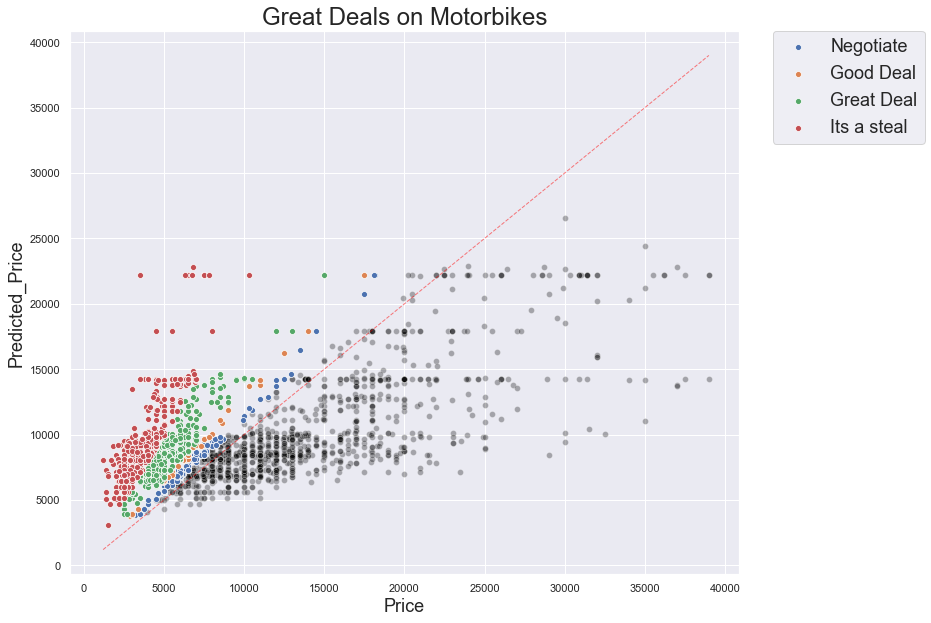

In [5]:
naive = run_pipeline(naive_feature, optimise=False)

In [6]:
#naive.df.head()

In [7]:
naive.model

{'Name': 'GradientBoostingRegressor',
 'Model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 'Features': ['Kilometers', 'Age'],
 'Score': 0.37566167302531006}

In [8]:
#brands = run_pipeline(brand_cols, optimise=False)

In [9]:
#models = run_pipeline(model_cols, optimise=False)

### Full Model

ARDRegression 0.8856608430513528
BayesianRidge 0.9005121397476328
ElasticNet 0.8353819628720458
ElasticNetCV 0.6108873925638295
Lars -2.2676422205273864e+88
LarsCV 0.7565273875154692
Lasso 0.891739495288611
LassoCV 0.6620188697594586
LassoLars 0.7976990420634088
LassoLarsCV 0.7971220170356403
LassoLarsIC 0.7952673324615773
LinearRegression 0.8060683755125124
OrthogonalMatchingPursuit 0.8487291326668821
OrthogonalMatchingPursuitCV 0.8487848237114445
PassiveAggressiveClassifier 0.01440121282943369
PassiveAggressiveRegressor -0.2466210518417064
Perceptron 0.004
Ridge 0.9013211060646033
RidgeClassifier 0.09384217636487575
RidgeClassifierCV 0.09756383112456732
RidgeCV 0.9005216781516804
SGDClassifier 0.00881173700192105
SGDRegressor -1.2068272273967885e+28
AdaBoostRegressor 0.8103161647612905
BaggingRegressor 0.9004056892689217
GradientBoostingRegressor 0.9023235851967268
RandomForestRegressor 0.8954887161801942
Model:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=Non

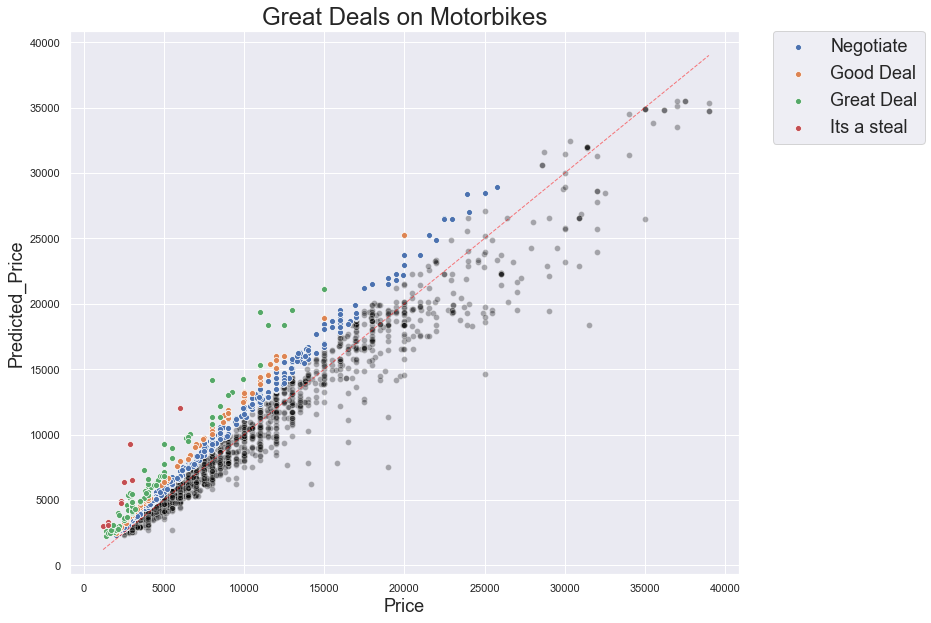

In [10]:
# NOTE:
# To reduce processing time change optimise flag to false so the model 
# hyperparameters are not tuned.
# optimise=False
allFeatures = run_pipeline(optimise=False)

In [11]:
allFeatures.model

{'Name': 'GradientBoostingRegressor',
 'Model': GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 'Features': ['Maximum_Power',
  'Age',
  'Width',
  'Kilometers',
  'Wet_Operational_Weight',
  'Brand_MV-Agusta',
  'Model_Ninja_ZX10RR_(ZX1000Z)',
  'Frame_Material_Chrome'],
 'Score': 0.9367773774281803}

In [12]:

pipeline = 'pipeline_model.pkl'

# Saving the objects:
with open(pipeline, 'wb') as f:
    pickle.dump(allFeatures, f)
    

In [13]:
def r_squared(y, y_pred):
    res = y - y_pred
    tot = y - y.mean()

    r2 = 1 - res.dot(res) / tot.dot(tot)
    return r2




In [14]:
naive_r2 = r_squared(naive.df['Price'], naive.df['Predicted_Price'])
#brands_r2 = r_squared(brands.df['Price'], brands.df['Predicted_Price'])
#models_r2 = r_squared(models.df['Price'], models.df['Predicted_Price'])
allFeatures_r2 = r_squared(allFeatures.df['Price'], allFeatures.df['Predicted_Price'])


In [15]:
print (f'r2 for all naive model: {naive_r2}')
#print (f'r2 for all brands model: {brands_r2}')
#print (f'r2 for all models model: {models_r2}')
print (f'r2 for all features model: {allFeatures_r2}')


r2 for all naive model: 0.3762419131061415
r2 for all features model: 0.9370124057648785


## Alternate Scenario

In [16]:
sport = bikeSales()
sport.read_data()
#sport.add_dummy_variables()

df = sport.df.copy(deep=True)

In [17]:
df.head()

,Bore,Compression_Ratio,Cylinders,Engine_Stroke,Engine_Voltage,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Tank_Capacity,Gear_Number,Ground_Clearance,...,Side_Stand_Start_Inhibitor,Starter,State,Swingarm_Type,Traction_Control,URL,Wheel_Type,Seller,Brand,Sold
0,97.000,11.0,2.0,4.0,12.0,320.00000,120.0,20.0,6.0,137.338051,...,No,Electric,QLD,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale
1,79.685,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,No,Electric,VIC,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale
2,79.685,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,No,Electric,NSW,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale
3,97.000,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,No,Electric,WA,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale
4,97.000,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,No,Electric,NSW,Dual_Sided,No,https://www.bikesales.com.au/bikes/details/200...,Spoke,Private,Aprilia,For Sale


### Helper functions

In [18]:

@interact
def Dealer_split_distribution(feature=df.columns):
    
    dealer = df[df['Seller'] == 'Dealer']
    private = df[df['Seller'] != 'Dealer']

    #column = set(list(sport.select_dtypes(exclude='number').columns)) - set(['Description'])
    ax = plt.figure(figsize=(12,10))
    
    if pd.api.types.is_numeric_dtype(df[feature]):
        ax = sns.distplot(dealer[feature])
        ax = sns.distplot(private[feature])

        #plt.gcf().set_size_inches(10,10)
        #ax.annotate(stats.pearsonr)
        plt.legend(labels=['Dealer','Private'])
    
    else:
        sns.countplot(x=feature, hue='Seller', data=df)

        
    plt.suptitle('Distribution for Seller Type',x=0.5,y=1.01,size=18)
    plt.xlabel(feature)

interactive(children=(Dropdown(description='feature', options=('Bore', 'Compression_Ratio', 'Cylinders', 'Engi…

In [19]:
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from scipy import stats

@interact
def plot_counts(x=df.select_dtypes(include='number'),
                y=df.select_dtypes(include='number'),
                hue=df.select_dtypes(exclude='number')):
    
    #column = set(list(sport.select_dtypes(exclude='number').columns)) - set(['Description'])
    ax = plt.figure(figsize=(12,10))
    correlation = df[x].corr(df['Price'])
    ax = sns.scatterplot(x=x,y=y,hue=hue,data=df)
    #plt.gcf().set_size_inches(10,10)
    #ax.annotate(stats.pearsonr)
    plt.suptitle('Relationship to '+x,x=0.5,y=1.01,size=18)
    plt.xlabel(x)


interactive(children=(Dropdown(description='x', options=('Bore', 'Compression_Ratio', 'Cylinders', 'Engine_Str…

# Inferred Dealer valuation

We will make the assumption that all dealers have a good idea of the true value of a motorbike, since they have mechanics and valuation experts available on staff. We can then build a model based on the dealer data to make predictions on the private sellers valuation.

The accuracy of this model will be based on the accuracy of prediction the dealer values.

In [20]:
def run_dealer_pipeline(features=None,optimise=True):
    
    sport = bikeSales()
    sport.read_data()
    sport.add_dummy_variables()
    
    if (features == None):
        features = list(set(sport.df.columns) - set(['Price']))
        
    # Ignore the URL feature
    update_features = []
    for feature in features:
        if 'URL' not in feature:
            update_features.append(feature)
    features = update_features
    dealer_X, dealer_y, private_X, private_y = sport.dealer_split_data(features)

    # reset the df to the dealer seller data
    original_df = sport.df
    training_df = dealer_X
    training_df['Price'] = dealer_y
    sport.df = training_df
    
    sport.find_best_model(features, sport.df['Price'])
    print ('Model: ',sport.model['Model'])
    print ('Score: ',sport.model['Score'])

    print ('Feature selection process.')
    sport.feature_selection(features)
    print ('Score: ',sport.model['Score'])
    
    # Optimise model parameters
    if optimise:
        print ('Optimising model')
        sport.optimise_best_model()
    
    # Fit the full model (all dealer data)
    sport.fit(sport.df[sport.model['Features']],sport.df['Price'])
    sport.re_score()
    
    # Reset the dataframe back to the dealer and private seller data
    sport.df = original_df
    
    # Make predictions
    predictions = sport.predict(sport.df[sport.model['Features']])
    sport.df['Predicted_Price'] = predictions
    sport.model['Model'].score(sport.df[sport.model['Features']], sport.df['Price'])
    
    # Determine the deal type
    sport.deal_type()

    # Display the predicted deals
    sport.plot_deals(x='Price',y='Predicted_Price',title='Great Deals on Motorbikes')
    print (f"Model score {sport.model['Score']}")
    
    return sport

### Dealer Model

ARDRegression 0.9021744965415148
BayesianRidge 0.9113444733341796
ElasticNet 0.8650876903421724
ElasticNetCV 0.6193569898562037
Lars -6.725160950662358e+99
LarsCV 0.4058811707302036
Lasso 0.904661497053511
LassoCV 0.6799535212916245
LassoLars 0.8263578843308853
LassoLarsCV 0.8127737133401641
LassoLarsIC 0.7857879180172347
LinearRegression -73246409705910.61
OrthogonalMatchingPursuit 0.8639660832268898
OrthogonalMatchingPursuitCV 0.8639845122289251
PassiveAggressiveClassifier 0.045708999860898596
PassiveAggressiveRegressor -0.3925342829558524
Perceptron 0.013406593406593406
Ridge 0.9107267511880064
RidgeClassifier 0.1639746835443038


C:\Users\Beau\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RidgeClassifierCV 0.16834830991793018
RidgeCV 0.9077931191122957
SGDClassifier 0.025982195020169706
SGDRegressor -1.4376646489240027e+28
AdaBoostRegressor 0.8695434847215335
BaggingRegressor 0.9063862166916727
GradientBoostingRegressor 0.9154755145565211
RandomForestRegressor 0.8968819637582124
Model:  GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
Score:  0.9154755145565211
Feature selection process.
Added feature: Maximum_Power with adjusted R^2 = 0.839
Added feature: Age with adjusted R^2 = 0.895
Added feature:

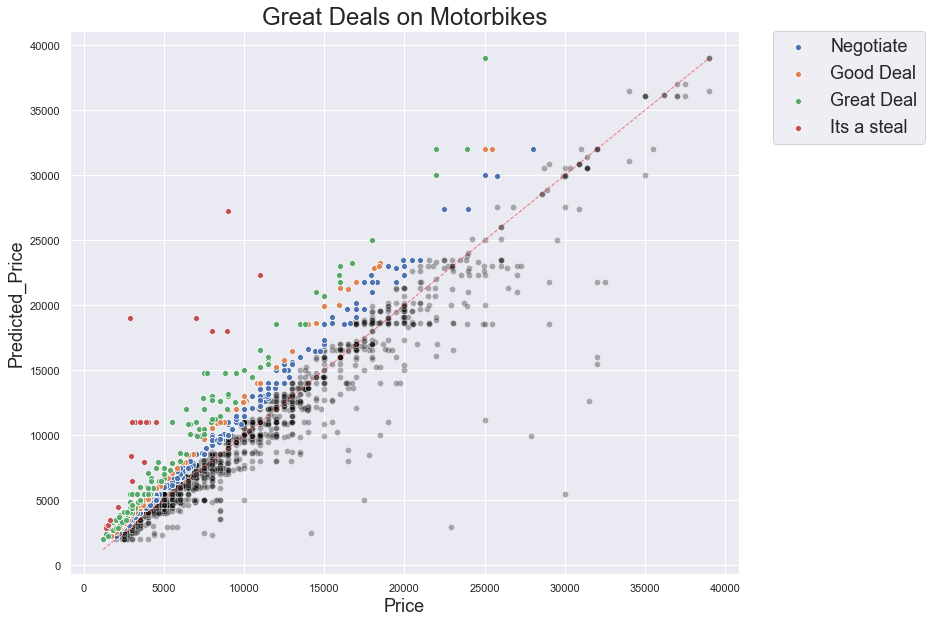

In [48]:

dealer_model = run_dealer_pipeline(optimise=True)


In [49]:

dealer_model.model

{'Name': 'GradientBoostingRegressor',
 'Model': GradientBoostingRegressor(alpha=0.1, criterion='mse', init=None,
              learning_rate=0.1, loss='ls', max_depth=15, max_features=None,
              max_leaf_nodes=None, min_impurity_decrease=0.0,
              min_impurity_split=None, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, n_iter_no_change=None, presort='auto',
              random_state=None, subsample=1.0, tol=0.0001,
              validation_fraction=0.1, verbose=0, warm_start=False),
 'Features': ['Maximum_Power',
  'Age',
  'Width',
  'Throttle_Bore',
  'Brand_MV-Agusta',
  'Cooling_Liquid',
  'Model_F3_800_RC',
  'State_SA',
  'Compression_Ratio',
  'Engine_Size',
  'Model_CBR500RA',
  'Model_CBR250R_SE_Repsol'],
 'Score': 0.9713806777424555,
 'score': 0.9738190536397457}

In [50]:

dealer_file = 'dealer_model.pkl'
# Saving the objects:
with open(dealer_file, 'wb') as f:
    pickle.dump(dealer_model, f)



In [51]:
df = dealer_model.df[dealer_model.df['Seller_Dealer'] == 1]
dealer_r2 = r_squared(df['Price'], df['Predicted_Price'])
print (f'Dealer r2 score: {dealer_r2}')

Dealer r2 score: 0.9717543794476683


In [52]:
test_df = dealer_model.df.copy(deep=True)
test_df.head()

# Find the its a steal bikes
#steal = test_df[test_df['Deal_Type'] == 'Its a steal']
#value = steal['Predicted_Price'].max()

#steal[steal['Predicted_Price'] == value]


,Bore,Compression_Ratio,Cylinders,Engine_Stroke,Engine_Voltage,Front_Brake_Diameter,Front_Suspension_Travel,Fuel_Tank_Capacity,Gear_Number,Ground_Clearance,...,Exhaust_Config_4_into_2,Exhaust_Config_4_into_4,Front_Brake_Caliper(s)_Double_Piston,Front_Brake_Caliper(s)_Four_Piston,Front_Brake_Caliper(s)_Single_Piston,Front_Brake_Caliper(s)_Six_Piston,Front_Brake_Caliper(s)_Triple_Piston,Predicted_Price,Price_ratio,Deal_type
0,97.000,11.0,2.0,4.0,12.0,320.00000,120.0,20.0,6.0,137.338051,...,0,0,0,1,0,0,0,10999.999937,0.500000,Great Deal
1,79.685,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,0,0,0,1,0,0,0,11994.996020,0.533556,Great Deal
2,79.685,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,0,0,0,1,0,0,0,11994.996020,0.625261,Great Deal
3,97.000,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,0,0,0,1,0,0,0,10840.925722,0.599580,Great Deal
4,97.000,12.0,2.0,4.0,12.0,309.35404,120.0,17.7,6.0,137.338051,...,0,0,0,1,0,0,0,10840.925722,0.608804,Great Deal


# Neural Network
Usinig a Neural Network model with the infered dealer valuation scenario.

In [26]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.


In [27]:
sport = bikeSales()
sport.read_data()
#sport.add_dummy_variables()

df = sport.df.copy(deep=True)

In [28]:
def add_dummy_variables(df, categorical_features=None):
        
    if (categorical_features == None):
        categorical_features = df.select_dtypes(exclude='number').columns

    # ignore the URL feature when training
    categorical_features = list(set(categorical_features) - set('URL'))

    additional = pd.get_dummies(df[categorical_features])
    df[additional.columns] = additional

    df.drop(categorical_features, axis=1, inplace=True)

    return df

In [29]:
# Create a feature describing the type of deal based on the ratio 
# of predicted price to sale price.
def deal_type(df):

    df['Price_ratio'] = df['Price'] / df['Predicted_Price']

    df['Deal_type'] = 'Dont Bother'
    df['Deal_type'][df['Price_ratio'] < 0.9] = 'Negotiate'
    df['Deal_type'][df['Price_ratio'] < 0.8] = 'Good Deal'
    df['Deal_type'][df['Price_ratio'] < 0.75] = 'Great Deal'        
    df['Deal_type'][df['Price_ratio'] < 0.5] = 'Its a steal'

    return df

# diplay the predicted price and sale price using the deal type feature 
# to distinguish a good deal.
def plot_deals(df, x, y, title='', figsize=(12,10)):

    negotiate = df[df['Deal_type'] == 'Negotiate']
    good = df[df['Deal_type'] == 'Good Deal']
    great = df[df['Deal_type'] == 'Great Deal']
    steal = df[df['Deal_type'] == 'Its a steal']

    ax = plt.figure(figsize=figsize)

    sns.scatterplot(x=x,y=y,data=df,color='black',alpha=0.3);
    sns.scatterplot(x=x,y=y,data=negotiate,label='Negotiate');
    sns.scatterplot(x=x,y=y,data=good,label='Good Deal');
    sns.scatterplot(x=x,y=y,data=great,label='Great Deal');
    sns.scatterplot(x=x,y=y,data=steal,label='Its a steal');
    ax = sns.lineplot(x=[df[x].min(),df[x].max()], y=[df[x].min(),df[x].max()],
                      linewidth=1, alpha=0.5, color='red')
    ax.lines[0].set_linestyle("--")
    
    plt.title(title,fontsize=24)
    plt.xlabel(x, fontsize=18)
    plt.ylabel(y, fontsize=18)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    return None


In [30]:
df = add_dummy_variables(df)


In [31]:

features = list(set(df.columns) - set(['Price']))

# Ignore the URL features
update_features = []
for feature in features:
    if 'URL' not in feature:
        update_features.append(feature)
features = update_features


In [32]:
def dealer_split_data(df,features):
        
    train = df[df['Seller_Dealer'] == 1]
    test = df[df['Seller_Dealer'] == 0]

    X_train, y_train = train[features], train['Price']
    X_test, y_test = test[features], test['Price']

    return X_train, y_train, X_test, y_test

In [33]:
dealer_X, dealer_y, private_X, private_y = dealer_split_data(df, features)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(dealer_X, dealer_y, random_state=1, test_size=0.3)


In [35]:
# Find the best architecture for the neural network
def run_neural_networks(X_train, X_test, y_train, y_test):
    n_cols = X_train.shape[1]
    hidden_layers = range(1,5)
    nodes = [50,100,150,200,300,500]
    
    results = {'hidden_layers': [],
               'nodes': [],
               'score': []}
    
    for layer in hidden_layers:

        for node in nodes:

            model = Sequential()
            
            model.add(Dense(n_cols, activation = 'relu', input_shape = (n_cols, )))
            
            if layer == 1:
                model.add(Dense(node, activation = 'relu'))
                
            if layer == 2:
                model.add(Dense(node, activation = 'relu'))
                model.add(Dense(node, activation = 'relu'))
            
            if layer == 3:
                model.add(Dense(node, activation = 'relu'))
                model.add(Dense(node, activation = 'relu'))
                model.add(Dense(node, activation = 'relu'))
                
            if layer == 4:
                model.add(Dense(node, activation = 'relu'))
                model.add(Dense(node, activation = 'relu'))
                model.add(Dense(node, activation = 'relu'))
                model.add(Dense(node, activation = 'relu'))

            if layer == 5:
                model.add(Dense(node, activation = 'relu'))
                model.add(Dense(node, activation = 'relu'))
                model.add(Dense(node, activation = 'relu'))
                model.add(Dense(node, activation = 'relu'))
                model.add(Dense(node, activation = 'relu'))

            # Add the output layer
            model.add(Dense(1, activation = 'linear'))
            
            model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])

            model.fit(X_train, y_train, validation_split = 0.25, batch_size = 20, epochs = 1000, verbose = 0)

            score = model.evaluate(X_test, y_test, batch_size = 20)
            
            results['hidden_layers'].append(layer)
            results['nodes'].append(node)
            results['score'].append(score[1])
            
            print (results['score'])
    
    
    return results    
    

In [36]:
results = run_neural_networks(X_train, X_test, y_train, y_test)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
276/276 [==============================] - 0s 51us/step
[3029979.4166666665]
276/276 [==============================] - 0s 51us/step
[3029979.4166666665, 3049733.170289855]
276/276 [==============================] - 0s 54us/step
[3029979.4166666665, 3049733.170289855, 3516367.4211956523]
276/276 [==============================] - 0s 62us/step
[3029979.4166666665, 3049733.170289855, 3516367.4211956523, 3812126.842391304]
276/276 [==============================] - 0s 54us/step
[3029979.4166666665, 3049733.170289855, 3516367.4211956523, 3812126.842391304, 3146275.1213768115]
276/276 [==============================] - 0s 83us/step
[3029979.4166666665, 3049733.170289855, 3516367.4211956523, 3812126.842391304, 3146275.1213768115, 3309369.3460144927]
276/276 [==============================] - 0s 65us/step
[3029979.4166666665, 3049733.170289855, 3516367.4211956523, 3812126.84

In [37]:
# Extract the features for the optimul architecture
results_df = pd.DataFrame.from_dict(results)
best = results_df[results_df['score'] == results_df['score'].min()]


In [38]:
best

,hidden_layers,nodes,score
0,1,50,3.029979e+06


In [39]:
def neural_network(X,y,results):
    
    layer = results['hidden_layers'].values[0]
    node = results['nodes'].values[0]
    n_cols = X.shape[1]

    model = Sequential()

    model.add(Dense(n_cols, activation = 'relu', input_shape = (n_cols, )))

    if layer == 1:
        model.add(Dense(node, activation = 'relu'))

    if layer == 2:
        model.add(Dense(node, activation = 'relu'))
        model.add(Dense(node, activation = 'relu'))

    if layer == 3:
        model.add(Dense(node, activation = 'relu'))
        model.add(Dense(node, activation = 'relu'))
        model.add(Dense(node, activation = 'relu'))

    if layer == 4:
        model.add(Dense(node, activation = 'relu'))
        model.add(Dense(node, activation = 'relu'))
        model.add(Dense(node, activation = 'relu'))
        model.add(Dense(node, activation = 'relu'))

    if layer == 5:
        model.add(Dense(node, activation = 'relu'))
        model.add(Dense(node, activation = 'relu'))
        model.add(Dense(node, activation = 'relu'))
        model.add(Dense(node, activation = 'relu'))
        model.add(Dense(node, activation = 'relu'))

    # Add the output layer
    model.add(Dense(1, activation = 'linear'))
    
    model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mse'])
    
    model.fit(X, y, validation_split = 0.25, batch_size = 20, epochs = 1000, verbose = 0)

    return model


In [40]:
# Run the optimal neural network
model = neural_network(dealer_X,dealer_y,best)


In [41]:
# Make predictions on the dealer and private seller data
df['Predicted_Price'] = model.predict(df[features])

In [42]:
# Create data frames of the data seperately
dealer_df = df[df['Seller_Dealer'] == 1]


In [43]:
# Calculate the R squared score from the full model
neural_network_r2 = r_squared(dealer_df['Price'], dealer_df['Predicted_Price'])
neural_network_r2

0.9498172601684183

In [44]:
df = deal_type(df)

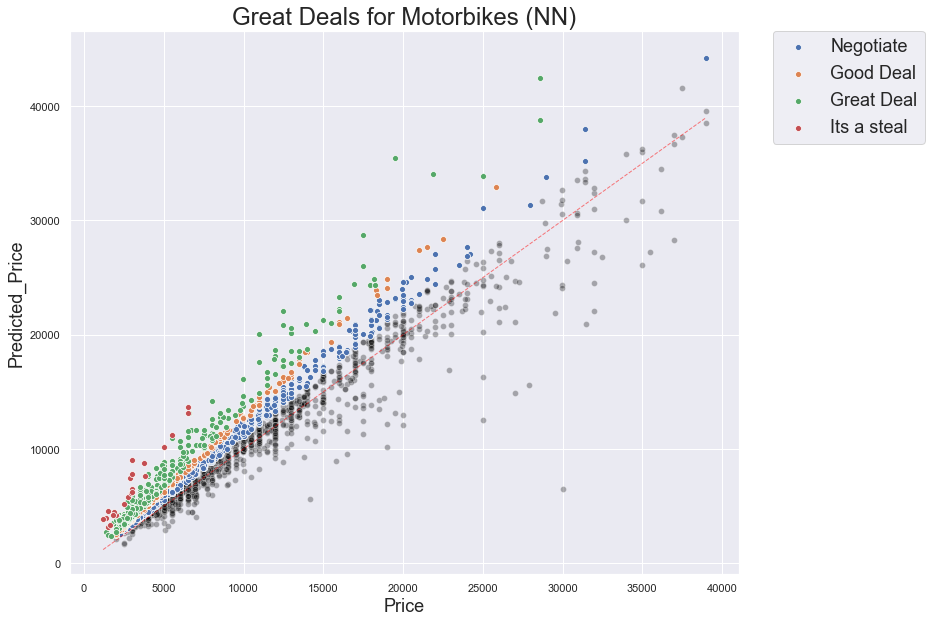

In [45]:
plot_deals(df, 'Price', 'Predicted_Price',title='Great Deals for Motorbikes (NN)')

In [46]:
# allFeatures2_r2

print ('Model Scores:\n'
       f'Linear regression model:           {allFeatures_r2}\n'
       f'Linear regression dealer scenario: {dealer_r2}\n'
       f'Neural Network dealer scenario:    {neural_network_r2}')


Model Scores:
Linear regression model:           0.9370124057648785
Linear regression dealer scenario: 0.9562631234286209
Neural Network dealer scenario:    0.9498172601684183


In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 396)               157212    
_________________________________________________________________
dense_110 (Dense)            (None, 50)                19850     
_________________________________________________________________
dense_111 (Dense)            (None, 1)                 51        
Total params: 177,113
Trainable params: 177,113
Non-trainable params: 0
_________________________________________________________________
